# Анализ вовлеченности пользователей в приложение



## Цели и задачи проекта



**Целью** проекта является выявление различия между вовлеченностью пользователей сервиса в Мосвке и Санкт-Петербурге. **Задача** - провести статистический тест на различие среднего времени прослушивания и чтения книг у пользователей двух городов.

## Описание данных



В данных представлена информация о пользователях и их суммарной длительности чтения и прослушивания книг в часах. Для эксеримента были отобраны пользователи из Москвы и Санкт-Петербурга.

## Содержимое проекта



1. Загрузка и первичный анализ данных
2. Проверка качества данных для проведения эксперимента
3. Проверка гипотезы эксперимента
4. Анализ результатов и составление выводов

## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [4]:
df = pd.read_csv('/datasets/yandex_knigi_data.csv')

In [5]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


None

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


В данных содержится **8 784** наблюдения и представлены 4 переменные: `Unnamed: 0` - дублирует индекс строки, `city` - название города, в котором находится пользователь, `puid` - идентификатор пользователя, `hours` - суммарное количество прослушанных/прочитанных часов пользователя. Пропуски в данных отсутствуют.

### Проверим необходимые условия для проведения теста:

In [6]:
#Сопоставимость групп:
shape_M = df[df['city'] == 'Москва'].shape[0]
shape_SP = df[df['city'] == 'Санкт-Петербург'].shape[0]
print(f' Количество наблюдений в Москве составляет: {shape_M}')
print(f' Количество наблюдений в Санкт-Петербурге составляет: {shape_SP}')

 Количество наблюдений в Москве составляет: 6234
 Количество наблюдений в Санкт-Петербурге составляет: 2550


В Москве наблюдений больше в два раза, однако количества данных в наименьшей группе достаточно для качественного теста.

In [7]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2 # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
mde = abs(df[df['city'] == 'Москва']['hours'].mean() - df[df['city'] == 'Санкт-Петербург']['hours'].mean()) /\
        df[df['city'] == 'Москва']['hours'].std()  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)
print(f"Разница между средними: {(abs(df[df['city'] == 'Москва']['hours'].mean() - df[df['city'] == 'Санкт-Петербург']['hours'].mean()))}")
print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Разница между средними: 0.71159871356822
Необходимый размер выборки для каждой группы: 42099


In [8]:
#Независимость наблюдений
df_city_check = df.groupby('puid')['city'].nunique().reset_index()
df_more_than_one_city = df_city_check[df_city_check['city'] > 1]
display(df_more_than_one_city)

,puid,city
48,2637041,2
173,9979490,2
188,10597984,2
196,10815097,2
249,13626259,2
...,...,...
8488,1130000018516717,2
8490,1130000018954257,2
8493,1130000020425037,2
8501,1130000023864516,2


244 пользователя присутствуют в обеих выборках, для чистоты эксперимента удалим эти данные:

In [9]:
df_cleaned = df[~df['puid'].isin(df_more_than_one_city['puid'])]
df_cleaned.shape[0]

8296

In [10]:
df_cleaned.duplicated().sum()

0

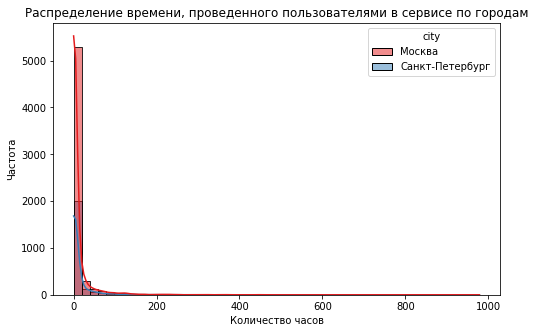

In [11]:
#Равномерность распределения

plt.figure(figsize=(8, 5))
sns.histplot(data=df_cleaned, x='hours', hue='city', bins=50, kde=True, palette='Set1', alpha=0.5)

plt.title('Распределение времени, проведенного пользователями в сервисе по городам')
plt.xlabel('Количество часов')
plt.ylabel('Частота')

plt.show()

In [12]:
display(df_cleaned[df_cleaned['city'] == 'Москва']['hours'].max())
display(df_cleaned[df_cleaned['city'] == 'Санкт-Петербург']['hours'].max())

857.2093727777777

978.7647747474748

В данных присутствуют аномально большие значения, которые могут исказить результаты теста, исключим их из анализа

In [13]:
df_final = df_cleaned[df_cleaned['hours'] <= df_cleaned['hours'].quantile(0.99)]

In [15]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2 # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
mde = abs(df_final[df_final['city'] == 'Москва']['hours'].mean() - df_final[df_final['city'] == 'Санкт-Петербург']['hours'].mean()) /\
        df_final[df_final['city'] == 'Москва']['hours'].std()  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)
print(f"Разница между средними: {(abs(df_final[df_final['city'] == 'Москва']['hours'].mean() - df_final[df_final['city'] == 'Санкт-Петербург']['hours'].mean()))}")

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Разница между средними: 0.3129370114961123
Необходимый размер выборки для каждой группы: 62424


Поскольку выбросы были отфильтрованы, разница между средними стала еще меньше, а следовательно увеличился размер выборки. Это уравнение можно решить относительно мощности теста:


In [16]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
mde = abs(df_final[df_final['city'] == 'Москва']['hours'].mean() - df_final[df_final['city'] == 'Санкт-Петербург']['hours'].mean()) /\
        df_final[df_final['city'] == 'Москва']['hours'].std()  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
power = power_analysis.power(
    effect_size = mde,
    nobs1 = df_final[df_final['city'] == 'Москва']['hours'].count(),
    alpha = alpha,
    ratio = df_final[df_final['city'] == 'Санкт-Петербург']['hours'].count() / df_final[df_final['city'] == 'Москва']['hours'].count()
)

print(f"Разница между средними: {(abs(df_final[df_final['city'] == 'Москва']['hours'].mean() - df_final[df_final['city'] == 'Санкт-Петербург']['hours'].mean()))}")
print(f"Мощность критерия: {power}")

Разница между средними: 0.3129370114961123
Мощность критерия: 0.09868795771344482


Результаты показывают, что мощность теста будет около 0.1. Т.е. вероятность правильно отвергнуть нулевую гипотезу, когда она неверна всего 10%.

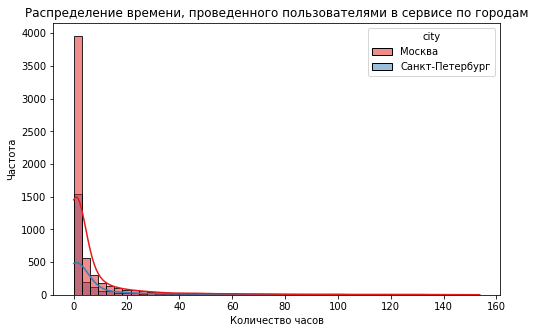

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df_final, x='hours', hue='city', bins=50, kde=True, palette='Set1', alpha=0.5)

plt.title('Распределение времени, проведенного пользователями в сервисе по городам')
plt.xlabel('Количество часов')
plt.ylabel('Частота')

plt.show()

Распределения одинаково смещены влево со средним значением, стремящемся к нулю, поэтому можно предположить, что присутствует нормальность выборочного среднего.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [18]:
# Для проверки различий используем тест Уэлча
df_M = df_final[df_final['city'] == 'Москва']['hours']
df_SPb = df_final[df_final['city'] == 'Санкт-Петербург']['hours']

test_result, test_pvalue = ttest_ind(
df_M,
df_SPb,
equal_var = False,
alternative='less'
)

alpha = 0.05

if test_pvalue > alpha:
    print(f'pvalue={test_pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу')

pvalue=0.2597525573920996 > 0.05
Не получилось отвергнуть нулевую гипотезу


Тесту не удалось опровергнуть нулевую гипотезу, это значит, что у нас недостаточно оснований полагать, что между городами существует статистически значимая разница в среднем показателе активности пользователей.

## 3. Аналитическая записка


- В данном эксперименте для проверки гипотез был выбран **t-тест Уэлча** с уровнем значимости **5%**;
- **p-value** теста получился равным **0.26**, что больше заданного уровня значимости;
- На основе полученного значения p-value мы **не смогли отвергнуть нулевую гипотезу**, а значит не смогли доказать, что средняя активность пользователей в Санкт-Петербурге больше, чем в Москве.
- На результат могла повлиять **разница в количестве наблюдений для городов**, также в данных присутствуют **аномально большие значения** даже после отсечения данных, превышающих 99 процентиль. Поэтому для сглаживания выбросов и более равномерного распределения данных между группами понадобится большее количество наблюдений, что положительно скажется на качестве эксперимента.